### Use a SOM to construct feature likelihood

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import abc

In [3]:
class MapGeometry(abc.ABC):
    
    def __init__(self, size):
        self._size = size
        self._separations = None
    
    @property
    def size(self):
        """The flattened size of this map.
        """
        return self._size
    
    @property
    def separations(self):
        """The matrix of pairwise separations between map nodes.
        
        Uses lazy evaluation.  The matrix might be sparse.
        """
        if self._separations is None:
            self._separations = self._calculate_separations()
        return self._separations
    
    @abc.abstractmethod
    def _calculate_separations(self):
        raise NotImplementedError()
        
    @abc.abstractmethod
    def plot(self, values, ax=None, **kwargs):
        """Plot a representation of the specified values for this map.
        
        Parameters
        ----------
        values : array
            1D array of length :attr:`size`    
        ax : matplotlib axis or None
            Plot axis to use, or create a default axis when None.
        kwargs : dict
            Additional plot keyword arguments to pass to the implementation.
        """
        raise NotImplementedError()

In [4]:
class Grid(MapGeometry):
    
    def __init__(self, *signature, metric='L2'):
        """Create a rectilinear grid map geometry.
        
        The grid shape is specified by the absolute values of the signature.        
        A negative value in the signature indicates that distances along the
        corresponding axis are calculated using wrap around.
        """
        shape = [abs(k) for k in signature]
        x = np.empty(shape=shape)
        super(Grid, self).__init__(x.size)
        self._shape = x.shape
        self._wrap = [k < 0 for k in signature]
        if metric not in ('L0', 'L1', 'L2'):
            raise ValueError('Invalid metric "{metric}", should be one of L0, L1, L2.')
        self._metric = metric
        
    @property
    def shape(self):
        return self._shape
    
    @property
    def wrap(self):
        return self._wrap
    
    @property
    def metric(self):
        return self._metric
    
    def _calculate_separations(self):
        ndim = len(self.shape)
        separation = np.zeros(self.shape + self.shape)
        # Loop over axes.
        for k, wrapk in enumerate(self._wrap):
            nk = self.shape[k]
            xk = np.arange(nk)
            # Calculate the the (nk, nk) matrix of absolute integer separations along the k-th axis.
            dxk = np.abs(xk.reshape(nk, 1) - xk)
            if wrapk:
                W = dxk > nk // 2
                dxk[W] *= -1
                dxk[W] += nk
            # Add this axis' contribution to the separation matrix.
            S = [(nk if (j % ndim == k) else 1) for j in range(2 * ndim)]
            dxk = dxk.reshape(S)
            if self._metric == 'L2':
                separation += dxk ** 2
            elif self._metric == 'L1':
                separation += dxk
            elif self._metric == 'L0':
                separation = np.maximum(separation, dxk)
        if self._metric == 'L2':
            # Take sqrt in place.
            np.sqrt(separation, out=separation)
        return separation.reshape(self.size, self.size)
    
    def plot(self, values, ax=None, **kwargs):
        """Plot an image of the input values.
        
        If the grid dimension is > 2, show a slice in the largest
        2 dimensions.
        """
        ndim = len(self.shape)
        if ndim == 1:
            # Plot a single row of values.
            values = values.reshape(1, self.size)
        elif ndim > 2:
            # Plot a slice in the largest 2 dimensions.
            largest = np.argsort(self.shape)[-2:]
            idx = [slice(None) if k in largest else 1 for k in range(ndim)]
            values = values[idx]
        ax = ax or plt.gca()
        ny, nx = values.shape
        ax.imshow(values, interpolation='none', origin='lower',
                  extent=[-0.5, nx - 0.5, -0.5, ny - 0.5], **kwargs)
        ax.axis('off')

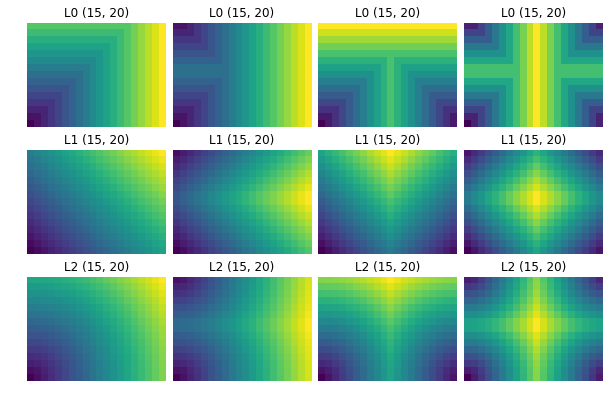

In [5]:
def grid_demo(ny=15, nx=20):
    fig, ax = plt.subplots(3, 4, figsize=(8, 5))
    for i, wrap in enumerate(((1, 1), (-1, 1), (1, -1), (-1, -1))):
        for j, metric in enumerate(('L0', 'L1', 'L2')):
            g = Grid(ny * wrap[0], nx * wrap[1], metric=metric)
            z = g.separations[0].reshape(g.shape)
            g.plot(z, ax=ax[j, i])
            ax[j, i].set_title('{} {}'.format(g.metric, g.shape))
    plt.subplots_adjust(left=0, right=1, wspace=0.05, hspace=0.2, bottom=0, top=1)
  
grid_demo()

In [6]:
class SelfOrganizingMap(object):
    
    def __init__(self, mapgeom):
        self._mapgeom = mapgeom
        
    def fit(self, data, maxiter=100, eta=0.5, init='random', seed=123):
        data = np.asarray(data)
        N, D = data.shape
        self._winner = np.empty(N, np.uint32)
        rng = np.random.RandomState(seed)
        if init == 'random':
            sigmas = np.std(data, axis=0)
            self._weights = sigmas.reshape(-1, 1) * rng.normal(size=(D, self._mapgeom.size))
        else:
            raise ValueError('Invalid init "{}".'.format(init))
        # Calculate mean separation between grid points as a representative large scale.
        large_scale = np.mean(self._mapgeom.separations)
        # Calculate the mean separation between N uniformly distributed points in D dimensions
        # as a representative small scale.
        volume = np.prod(self._mapgeom.shape)
        small_scale = (volume / N) ** (1 / D)
        assert small_scale < large_scale, 'Check the scales!'
        scale = large_scale
        dscale = (small_scale / large_scale) ** (1 / maxiter)
        for i in range(maxiter):
            loss = 0.
            for j, x in enumerate(data):
                # Calculate the Euclidean data-space distance squared between x and
                # each map site's weight vector.
                dx = x.reshape(-1, 1) - self._weights
                distsq = np.sum(dx ** 2, axis=0)
                # Find the map site with the smallest distance (largest dot product).
                self._winner[j] = k = np.argmin(distsq)
                # The loss is the sum of smallest (data space) distances for each data point.
                loss += np.sqrt(distsq[k])
                # Update all weights (dz are map-space distances).
                dz = self._mapgeom.separations[k]
                self._weights += eta * np.exp(-0.5 * (dz / scale) ** 2) * dx
            yield i, loss
            # Lower the scale for the next iteration.
            scale *= dscale

In [7]:
cd = {name: matplotlib.colors.to_rgba(color)[:3] for name, color in matplotlib.colors.CSS4_COLORS.items()}
cn = sorted(cd.keys())[:25]
c = [cd[name] for name in cn]
c = np.asarray(c)

In [8]:
sigs = np.std(c, axis=0)

In [9]:
rng = np.random.RandomState(123)
wts = sigs.reshape(-1, 1) * rng.normal(size=(c.shape[1], Grid(-50,-50).size))

In [10]:
np.argmin(np.sum((c[0].reshape(-1,1) - wts) ** 2, axis=0))

1836

In [11]:
wts.shape

(3, 2500)

In [12]:
def colors_demo(ncolors=25, nmap=-50, niter=100, eta=0.1):
    
    # Lookup all named colors in matplotlib.
    color_dict = {name: matplotlib.colors.to_rgba(color)[:3] for name, color in matplotlib.colors.CSS4_COLORS.items()}
    
    # Use the first ncolors.
    color_names = sorted(color_dict.keys())[:ncolors]
    colors = [color_dict[name] for name in color_names]
    
    # Build the self-organizing map.
    som = SelfOrganizingMap(Grid(nmap, nmap))
    losses = []
    for it, loss in som.fit(colors, maxiter=niter, eta=eta):
        losses.append(loss)

    # Plot the results.
    fig, ax = plt.subplots(2, 1, figsize=(8, 16))
    img = som._weights.T
    img = (img - img.min(axis=0)) / (img.max(axis=0) - img.min(axis=0))
    ax[0].imshow(img.reshape(abs(nmap), abs(nmap), 3), interpolation='none', origin='lower')
    for i, (color, name) in enumerate(zip(colors, color_names)):
        k = som._winner[i]
        y, x  = np.unravel_index(k, som._mapgeom.shape)
        ax[0].text(x, y, name, horizontalalignment='center',
                   verticalalignment='center', fontsize='medium')
    ax[0].axis('off')
    ax[1].plot(losses, 'ko')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Training Loss')
    plt.tight_layout()

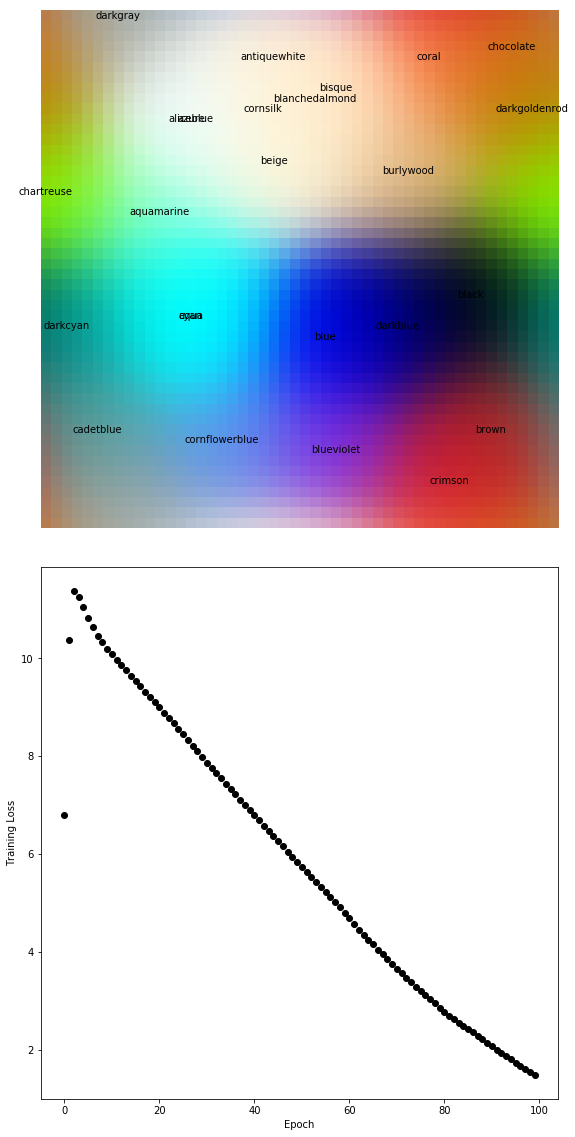

In [13]:
colors_demo()

In [14]:
from astropy.table import Table
import time

In [105]:
def u_matrix(som):
    
    '''Add option to interpolate onto finer grid
    
    From p. 337 of this paper https://link.springer.com/content/pdf/10.1007%2F978-3-642-15381-5.pdf'''
    
    rows, cols, D = som.shape
    
    u_matrix = np.empty((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            dist = 0
            ## neighbor above
            if i < rows - 1:
                dist += np.sqrt(np.sum((som[i,j] - som[i+1,j]) ** 2))
            ## neighbor below
            if i > 0:
                dist += np.sqrt(np.sum((som[i,j] - som[i-1,j]) ** 2))
            ## neighbor left
            if j > 0:
                dist += np.sqrt(np.sum((som[i,j] - som[i,j-1]) ** 2))
            ## neighbor right
            if j < cols - 1:
                dist += np.sqrt(np.sum((som[i,j] - som[i,j+1]) ** 2))
            u_matrix[i,j] = np.sum(dist)

                
    ## interpolate u_matrix onto (2X-1) x (2Y-1) grid
    #x = np.arange(0,rows - interp_int, interp_int)
    #y = np.arange(0,cols - interp_int, interp_int)
            
    return(u_matrix)

In [106]:
test_u = u_matrix(galaxy_som10)

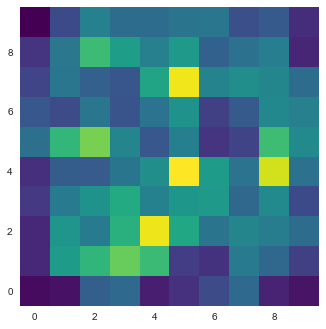

In [107]:
plt.imshow(test_u, origin='lower', interpolation='none', cmap='viridis')
plt.grid(None)
plt.show()

In [115]:
def galaxy_demo(colors, nmap=-50, niter=100, eta=0.1):
    
    # Build the self-organizing map.
    som = SelfOrganizingMap(Grid(nmap, nmap))
    losses = []
    for it, loss in som.fit(colors, maxiter=niter, eta=eta):
        losses.append(loss)
        
    N, D = colors.shape

    # Plot the results.
    fig, ax = plt.subplots(2, 1, figsize=(8, 16))
    img = som._weights.T
    img = (img - img.min(axis=0)) / (img.max(axis=0) - img.min(axis=0))
    u_map = u_matrix(img.reshape(abs(nmap), abs(nmap), D))
    ax[0].imshow(u_map, interpolation='none', origin='lower', cmap='viridis')
    ax[0].axis('off')
    ax[1].plot(losses, 'ko')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Training Loss')
    plt.tight_layout()
    
    return(img.reshape(abs(nmap), abs(nmap), D))

In [16]:
gc_data_mag_cut = Table.read('/Users/belaabolfathi/Documents/UCI/LSST DESC/PZ/cosmoDC2_mag_coord_cut.fits', format='ascii')
select_ra = np.logical_and(gc_data_mag_cut['ra'] >= 65.4, gc_data_mag_cut['ra'] < 65.8)
gc_ra_cut = gc_data_mag_cut[select_ra]
select_dec = np.logical_and(gc_ra_cut['dec'] >= -44.4, gc_ra_cut['dec'] < -44.)
gc_cut = gc_ra_cut[select_dec]

In [48]:
u_g = gc_cut['mag_u'] - gc_cut['mag_g']
g_r = gc_cut['mag_g'] - gc_cut['mag_r']
r_i = gc_cut['mag_r'] - gc_cut['mag_i']
i_z = gc_cut['mag_i'] - gc_cut['mag_z']
z_y = gc_cut['mag_z'] - gc_cut['mag_y']
redshift = gc_cut['redshift']
colors = np.asarray([u_g, g_r, r_i, i_z, z_y, redshift]).T

#### Visualize the data as a pairplot

In [49]:
import seaborn as sns
import pandas as pd

In [51]:
df = pd.DataFrame(colors, columns=('u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'redshift'))

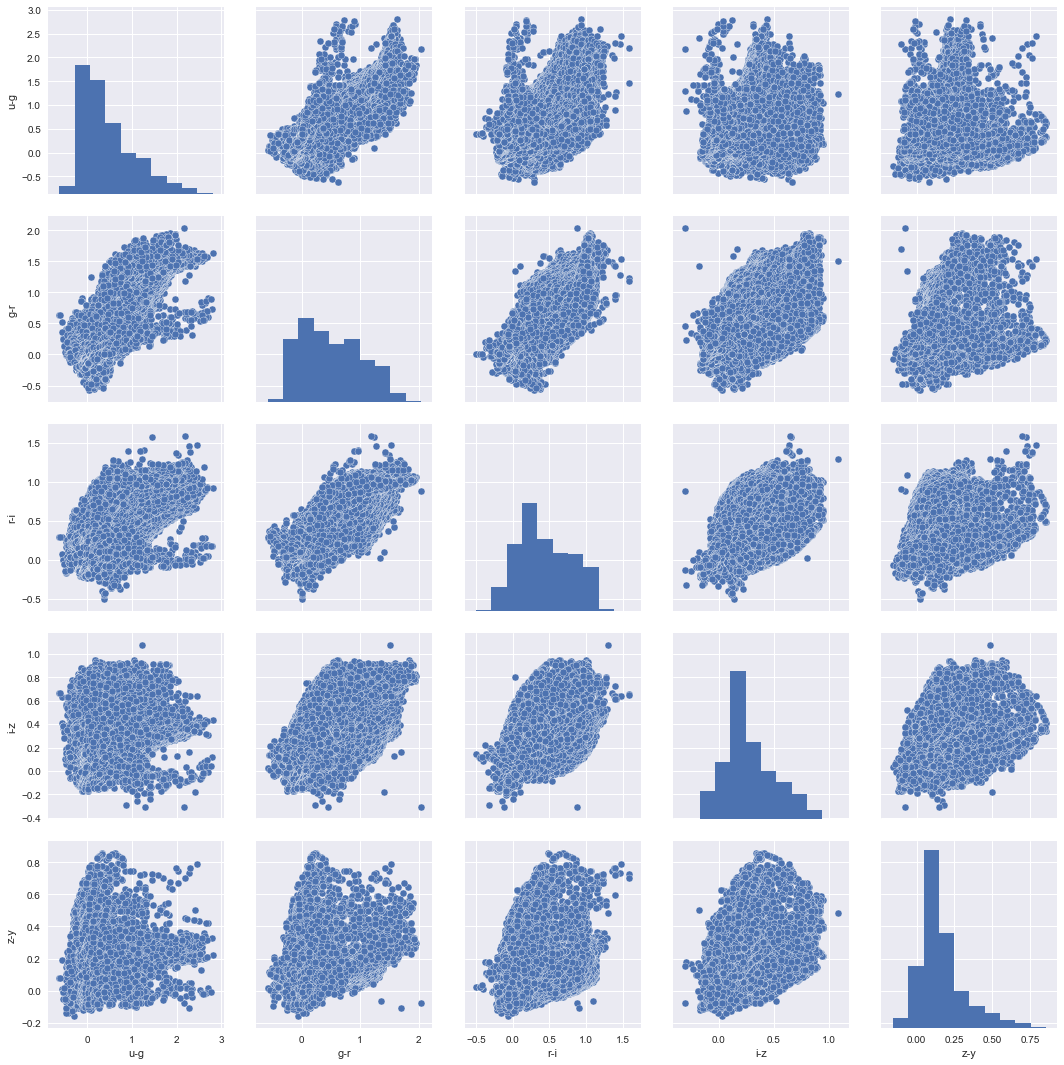

In [53]:
sns.pairplot(df.loc[:,'u-g':'z-y'], size=3, aspect=1)

### Understand 10x10 resolution SOM grid

79.94954991340637


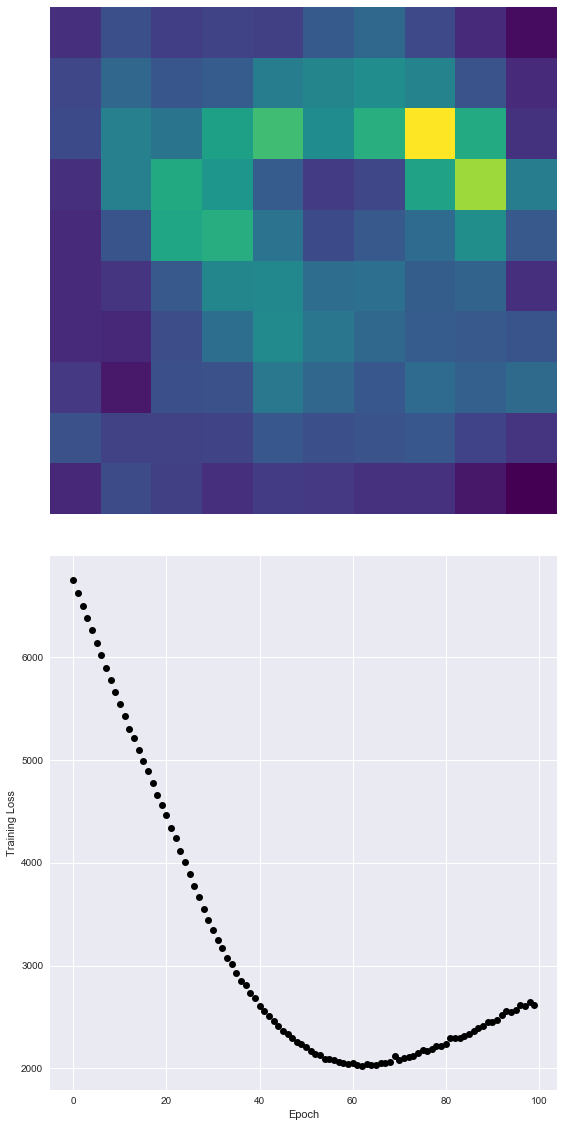

In [116]:
## imshow can only plot up to 4D in the last axis
res = -10
start = time.time()
galaxy_som10 = galaxy_demo(df.loc[:,'u-g':'z-y'], nmap=res)
print(time.time() - start)

- Why is training loss getting better then worse? Is it because zero is cut-off? No - looks like ~1800 is actually the smallest value...
- Is it getting worse then better because we are using too many iterations? Try with fewer (50) iterations
- I thought loss was the cumuluative sum of smallest distance between input vector and weight vector - so why is it increasing? It's because each loss value is the cumulative loss for all input vectors for a particular iteration

41.367615938186646


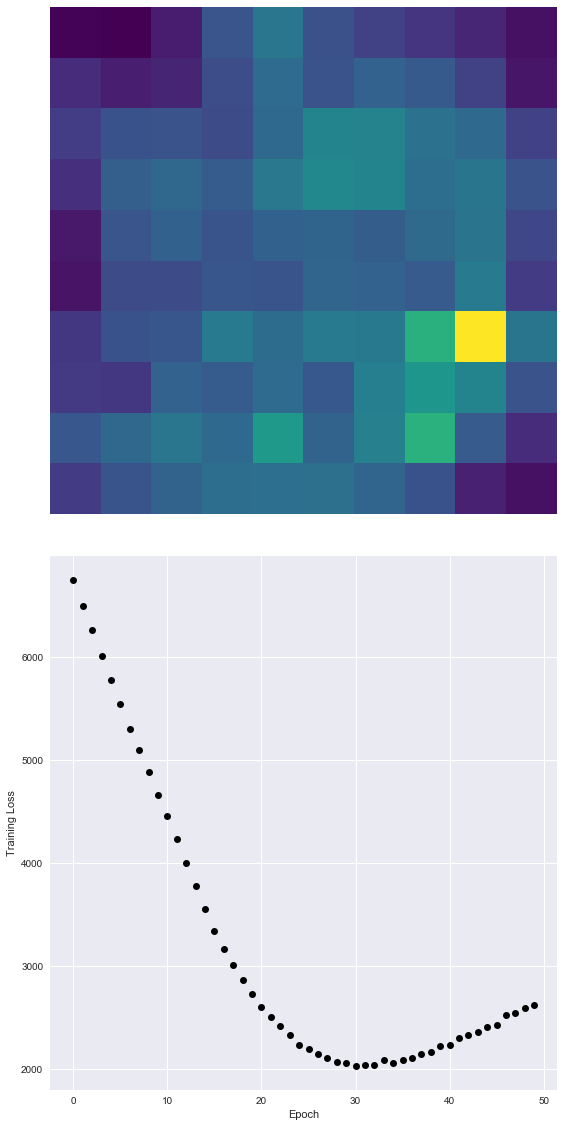

In [117]:
## imshow can only plot up to 4D in the last axis
res = -10
start = time.time()
galaxy_som10 = galaxy_demo(df.loc[:,'u-g':'z-y'], nmap=res, niter=50)
print(time.time() - start)

Try changing eta:

42.91395115852356


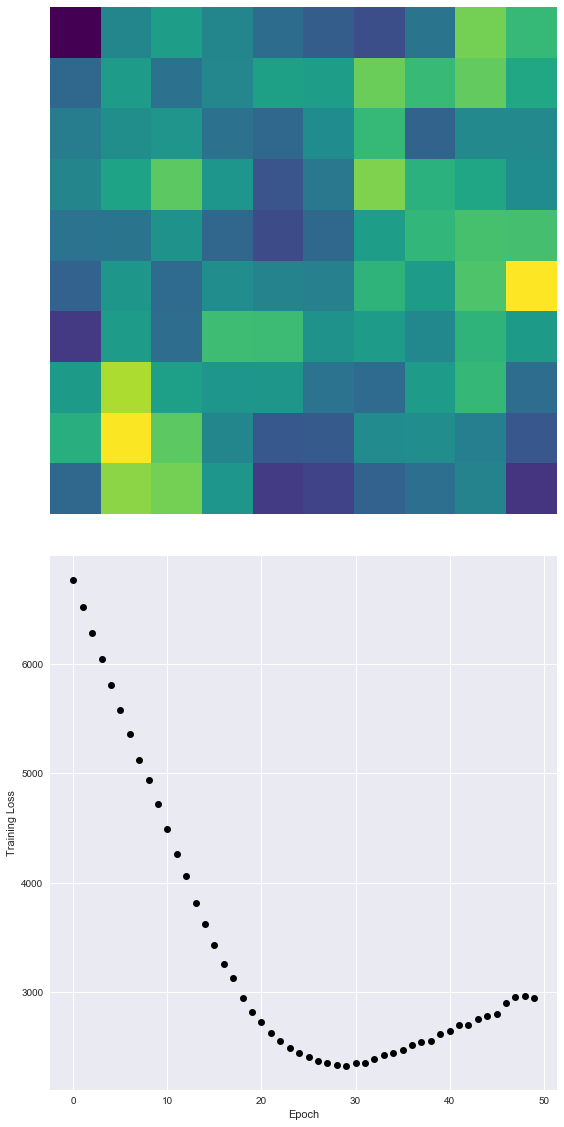

In [128]:
## imshow can only plot up to 4D in the last axis
res = -10
start = time.time()
galaxy_som10 = galaxy_demo(df.loc[:,'u-g':'z-y'], nmap=res, niter=50, eta=.05)
print(time.time() - start)

In [ ]:
def map_galaxies_to_som(data, som, statistic='mean'):
    
    rows, cols, D = som.shape
    
    assert rows == cols
    
    som_cell = np.empty(len(data), dtype=int)
    for i, j in enumerate(data):
        dx = j.reshape(-1,1) - som.reshape(-1,rows**2)
        distsq = np.sum(dx ** 2, axis=0)
        som_cell[i] = np.argmin(distsq)
    counts = np.bincount(som_cell, minlength=100)
    
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    axs = axs.ravel()
    
    im0 = axs[0].imshow(counts.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    fig.colorbar(im, ax=axs[0])
    
    im1 = axs[1].

In [123]:
for i, j in enumerate(df):
    print(i,j)

0 u-g
1 g-r
2 r-i
3 i-z
4 z-y
5 redshift


In [131]:
som_cell = np.empty(len(colors), dtype=int)
for i, j in enumerate(colors[:,:-1]):
    dx = j.reshape(-1,1) - galaxy_som10.reshape(-1,100)
    distsq = np.sum(dx ** 2, axis=0)
    som_cell[i] = np.argmin(distsq)

In [132]:
bc = np.bincount(som_cell, minlength=100)

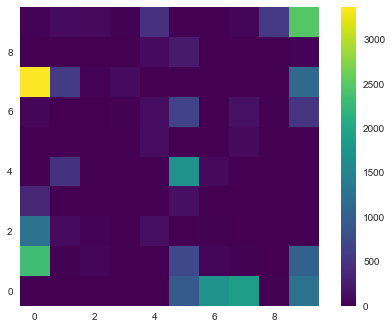

In [135]:
plt.imshow(bc.reshape(10,10), origin='lower', interpolation='none', cmap='viridis')
plt.grid(None)
plt.colorbar()
plt.show()

In [ ]:
## make sns.corner plot of u-g, etc colors
## increase colors in SOM
## consider using more galaxies to make the som (then gradually decrease to see how it degrades the som)
## avg/med z in each cell
## min/max/std of z in each cell
## look at masters som paper to get a feel for what paramters to use for SOM

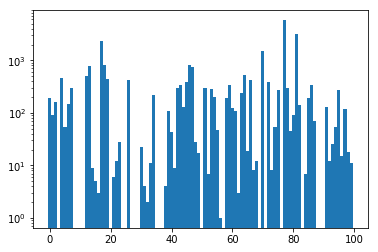

In [172]:
plt.hist(som_cell, bins=np.linspace(-0.5, 99.5, num=101))
plt.yscale('log')
plt.show()

In [150]:
np.mean(galaxy_som10.reshape(3,100)[0]), np.std(galaxy_som10.reshape(3,100)[0])

(0.49083048430439974, 0.3023326369026805)

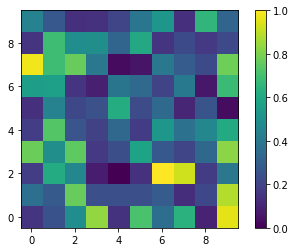

In [168]:
plt.imshow(galaxy_som10[:,:,0], origin='lower', interpolation='none')
plt.colorbar()
plt.show()

In [171]:
np.std(galaxy_som10[:,:,0])

0.24803645561390922

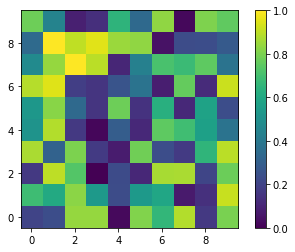

In [169]:
plt.imshow(galaxy_som10[:,:,1], origin='lower', interpolation='none')
plt.colorbar()
plt.show()

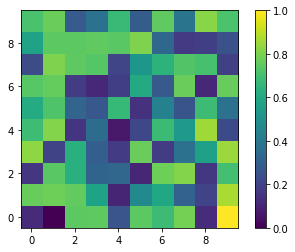

In [170]:
plt.imshow(galaxy_som10[:,:,2], origin='lower', interpolation='none')
plt.colorbar()
plt.show()

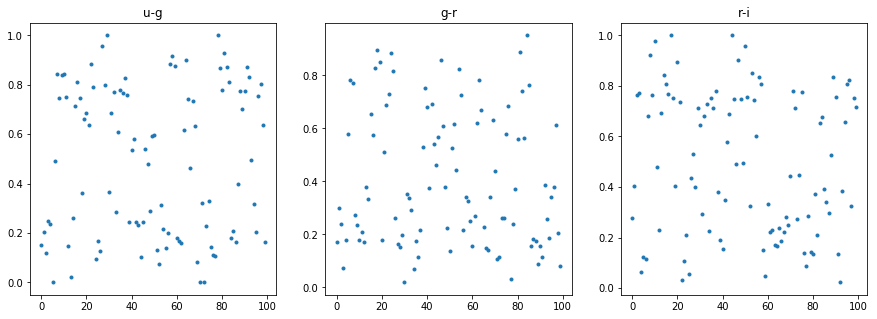

In [120]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs = axs.ravel()

axs[0].plot(galaxy_som10.reshape(-1,100)[0], '.')
axs[0].set_title('u-g')

axs[1].plot(galaxy_som10.reshape(-1,100)[1], '.')
axs[1].set_title('g-r')

axs[2].plot(galaxy_som10.reshape(-1,100)[2], '.')
axs[2].set_title('r-i')

plt.show()

(3, 1024)
119.52241897583008


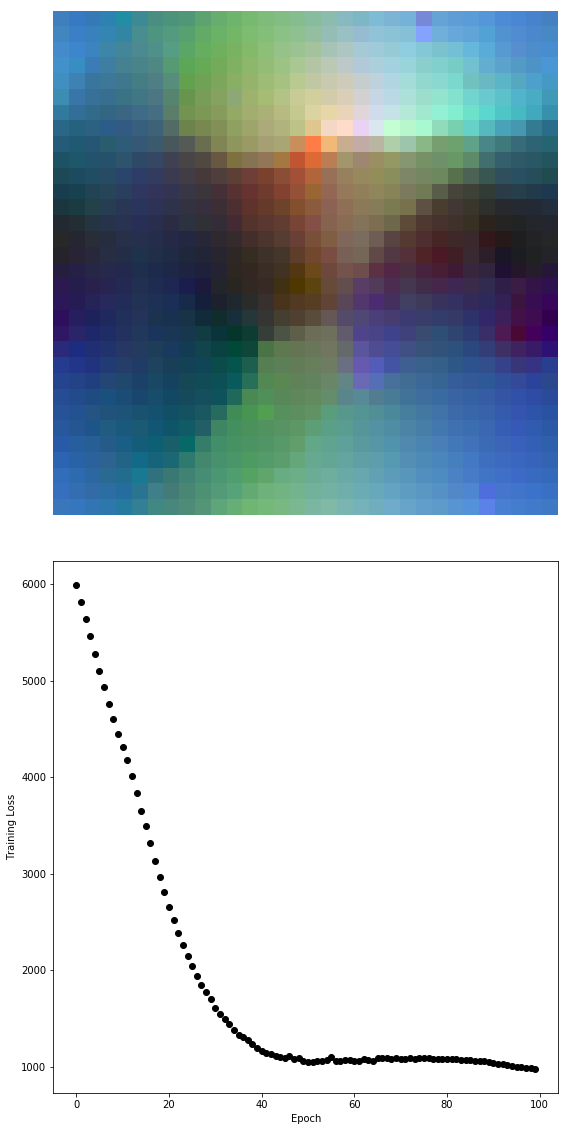

In [73]:
# resolution = 32
start = time.time()
galaxy_som32 = galaxy_demo(colors, nmap=-32)
print(time.time() - start)

#### Map each galaxy to its cell in the SOM

In [95]:
som_cell = np.empty(len(colors), dtype=int)
for i, j in enumerate(colors):
    dx = j.reshape(-1,1) - galaxy_som32.reshape(-1,32*32)
    distsq = np.sum(dx ** 2, axis=0)
    som_cell[i] = np.argmin(distsq)

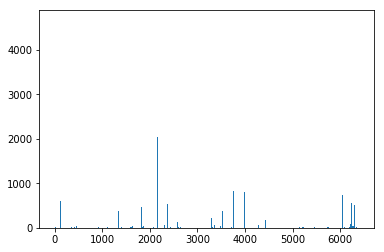

In [144]:
plt.hist(som_cell, bins=32*32)
plt.show()

In [100]:
som_cell[0] // 32, som_cell[0] % 32

(2, 19)

In [105]:
len(np.argwhere(som_cell == 1))

1189

In [109]:
galaxy_som.reshape(-1,32*32)[0].shape

(1024,)

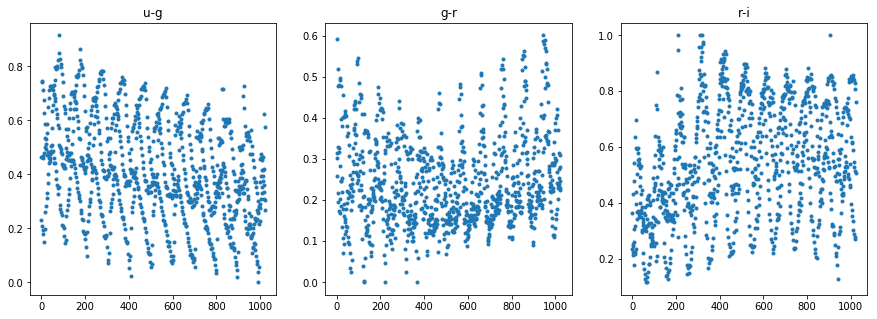

In [116]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs = axs.ravel()

axs[0].plot(galaxy_som.reshape(-1,32*32)[0], '.')
axs[0].set_title('u-g')

axs[1].plot(galaxy_som.reshape(-1,32*32)[1], '.')
axs[1].set_title('g-r')

axs[2].plot(galaxy_som.reshape(-1,32*32)[2], '.')
axs[2].set_title('r-i')

plt.show()

In [117]:
for i in range(3):
    print(np.std(galaxy_som.reshape(-1,32*32)[i]))

0.18260220461937707
0.10865101692673389
0.20235941930727383


Too much variation per cell...try increasing resolution to 50:

(3, 2500)
228.89204001426697


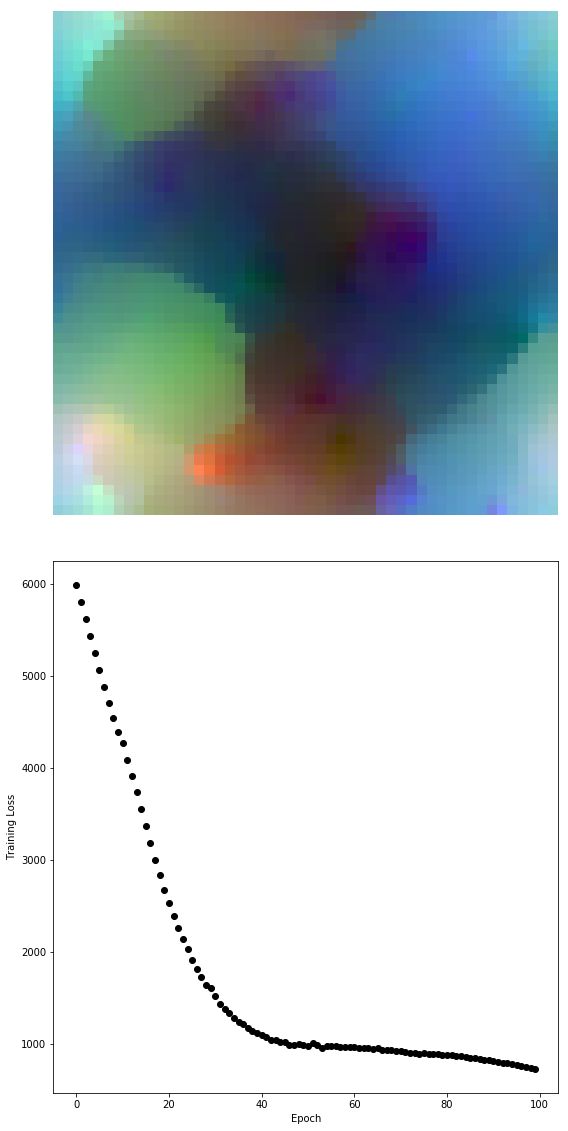

In [122]:
# resolution = 50
res = -50
start = time.time()
galaxy_som50 = galaxy_demo(colors, nmap=res)
print(time.time() - start)

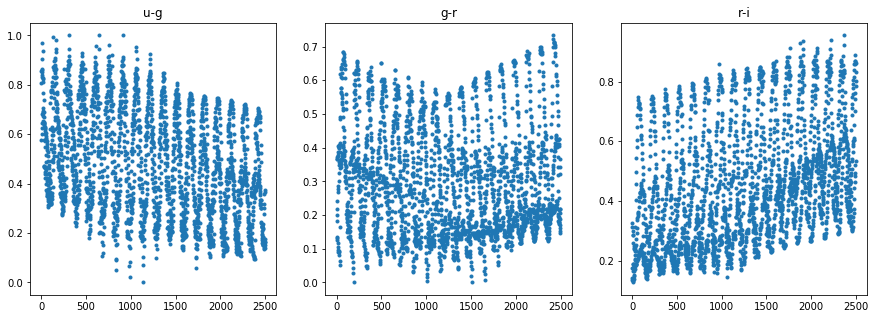

In [132]:
data = galaxy_som50

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs = axs.ravel()

axs[0].plot(data.reshape(-1,res**2)[0], '.')
axs[0].set_title('u-g')

axs[1].plot(data.reshape(-1,res**2)[1], '.')
axs[1].set_title('g-r')

axs[2].plot(data.reshape(-1,res**2)[2], '.')
axs[2].set_title('r-i')

plt.show()

In [133]:
np.std(data.reshape(-1,res**2)[0])

0.21530881034933164

In [134]:
np.mean(data.reshape(-1,res**2)[0])

0.4827595425213935

In [136]:
som_cell = np.empty(len(colors), dtype=int)
for i, j in enumerate(colors):
    dx = j.reshape(-1,1) - data.reshape(-1,res**2)
    distsq = np.sum(dx ** 2, axis=0)
    som_cell[i] = np.argmin(distsq)

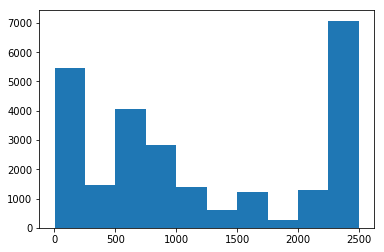

In [137]:
plt.hist(som_cell)
plt.show()

436.99661898612976


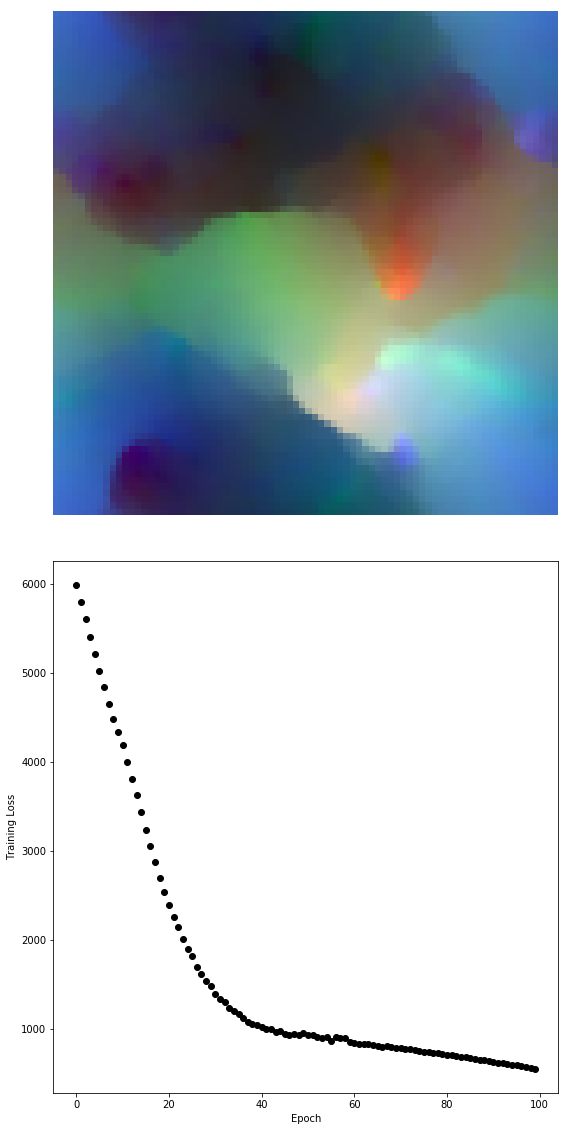

In [138]:
res = -80
start = time.time()
galaxy_som80 = galaxy_demo(colors, nmap=res)
print(time.time() - start)

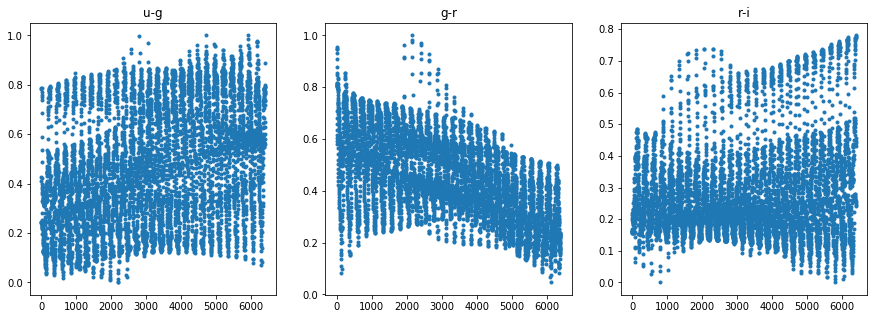

In [139]:
data = galaxy_som80

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs = axs.ravel()

axs[0].plot(data.reshape(-1,res**2)[0], '.')
axs[0].set_title('u-g')

axs[1].plot(data.reshape(-1,res**2)[1], '.')
axs[1].set_title('g-r')

axs[2].plot(data.reshape(-1,res**2)[2], '.')
axs[2].set_title('r-i')

plt.show()

In [140]:
np.std(data.reshape(-1,res**2)[0])

0.2390460868791851

In [141]:
som_cell = np.empty(len(colors), dtype=int)
for i, j in enumerate(colors):
    dx = j.reshape(-1,1) - data.reshape(-1,res**2)
    distsq = np.sum(dx ** 2, axis=0)
    som_cell[i] = np.argmin(distsq)

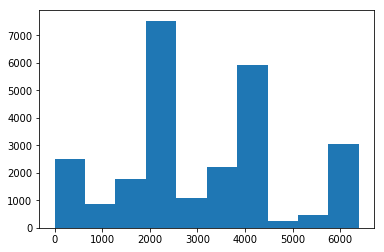

In [142]:
plt.hist(som_cell)
plt.show()